# Model 1: Unsupervised Learning - Discovering Player Personas

### Objective
The goal of this notebook is to use unsupervised clustering algorithms to discover natural, underlying patterns in player behavior. Instead of relying on pre-defined labels like 'High Spender', we want the data itself to reveal distinct groups or "personas" of players based on their characteristics and in-game habits.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
df = pd.read_csv('data/mobile_game_inapp_purchases.csv')

In [3]:
df.head()

,UserID,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,SpendingSegment,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseDate
0,c9889ab0-9cfc-4a75-acd9-5eab1df0015c,49.0,Male,Norway,Android,Battle Royale,9,12.83,Minnow,11.40,28.0,Apple Pay,2025-03-19
1,7c9e413c-ecca-45f2-a780-2826a07952a2,15.0,Male,Switzerland,iOS,Action RPG,11,19.39,Minnow,6.37,18.0,Debit Card,2025-06-08
2,fd61e419-1a92-4f43-a8c7-135842ad328a,23.0,Male,China,Android,Fighting,9,8.87,Minnow,15.81,30.0,Apple Pay,2025-06-02
3,bdb7f6d1-ff9a-468c-afe7-43f32a94293e,31.0,Male,Mexico,Android,Racing,12,19.56,Minnow,13.49,9.0,Debit Card,2025-04-01
4,aa7eec14-4846-47b9-b879-9c98038cda04,37.0,Female,India,Android,Battle Royale,10,15.23,Minnow,10.86,15.0,Paypal,2025-05-05


In [4]:
df.isna().sum()

UserID                             0
Age                               60
Gender                            60
Country                           60
Device                            60
GameGenre                         60
SessionCount                       0
AverageSessionLength               0
SpendingSegment                    0
InAppPurchaseAmount              136
FirstPurchaseDaysAfterInstall    136
PaymentMethod                    136
LastPurchaseDate                 136
dtype: int64

In [5]:
# Numerical Imputation
df['Age'].fillna(df['Age'].median(), inplace=True)
df['InAppPurchaseAmount'].fillna(df['InAppPurchaseAmount'].median(), inplace=True)
df['FirstPurchaseDaysAfterInstall'].fillna(df['FirstPurchaseDaysAfterInstall'].median(), inplace=True)

# Categorical Imputation
categorical_cols_with_na = ['Gender', 'Country', 'Device', 'GameGenre', 'PaymentMethod', 'LastPurchaseDate']
for col in categorical_cols_with_na:
    df[col].fillna('Unknown', inplace=True)


In [6]:
df.isna().sum()

UserID                           0
Age                              0
Gender                           0
Country                          0
Device                           0
GameGenre                        0
SessionCount                     0
AverageSessionLength             0
SpendingSegment                  0
InAppPurchaseAmount              0
FirstPurchaseDaysAfterInstall    0
PaymentMethod                    0
LastPurchaseDate                 0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   UserID                         3024 non-null   object 
 1   Age                            3024 non-null   float64
 2   Gender                         3024 non-null   object 
 3   Country                        3024 non-null   object 
 4   Device                         3024 non-null   object 
 5   GameGenre                      3024 non-null   object 
 6   SessionCount                   3024 non-null   int64  
 7   AverageSessionLength           3024 non-null   float64
 8   SpendingSegment                3024 non-null   object 
 9   InAppPurchaseAmount            3024 non-null   float64
 10  FirstPurchaseDaysAfterInstall  3024 non-null   float64
 11  PaymentMethod                  3024 non-null   object 
 12  LastPurchaseDate               3024 non-null   o

In [8]:
df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'], errors='coerce')
df['Age'] = df['Age'].astype('int64')
df['SessionCount'] = df['SessionCount'].astype('int64')
df['FirstPurchaseDaysAfterInstall'] = df['FirstPurchaseDaysAfterInstall'].astype('int64')

In [9]:
df['LastPurchaseYear'] = df['LastPurchaseDate'].dt.year
df['LastPurchaseMonth'] = df['LastPurchaseDate'].dt.month
df['LastPurchaseDayOfWeek'] = df['LastPurchaseDate'].dt.dayofweek
df['LastPurchaseYear'].fillna(df['LastPurchaseYear'].median(), inplace=True)
df['LastPurchaseMonth'].fillna(df['LastPurchaseMonth'].median(), inplace=True)
df['LastPurchaseDayOfWeek'].fillna(df['LastPurchaseDayOfWeek'].median(), inplace=True)
df['LastPurchaseYear'] = df['LastPurchaseYear'].astype('int64')
df['LastPurchaseMonth'] = df['LastPurchaseMonth'].astype('int64')
df['LastPurchaseDayOfWeek'] = df['LastPurchaseDayOfWeek'].astype('int64')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   UserID                         3024 non-null   object        
 1   Age                            3024 non-null   int64         
 2   Gender                         3024 non-null   object        
 3   Country                        3024 non-null   object        
 4   Device                         3024 non-null   object        
 5   GameGenre                      3024 non-null   object        
 6   SessionCount                   3024 non-null   int64         
 7   AverageSessionLength           3024 non-null   float64       
 8   SpendingSegment                3024 non-null   object        
 9   InAppPurchaseAmount            3024 non-null   float64       
 10  FirstPurchaseDaysAfterInstall  3024 non-null   int64         
 11  PaymentMethod    

In [11]:
df_model = df.drop(columns=['UserID', 'LastPurchaseDate'])

In [12]:
df_model.head()

,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,SpendingSegment,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek
0,49,Male,Norway,Android,Battle Royale,9,12.83,Minnow,11.40,28,Apple Pay,2025,3,2
1,15,Male,Switzerland,iOS,Action RPG,11,19.39,Minnow,6.37,18,Debit Card,2025,6,6
2,23,Male,China,Android,Fighting,9,8.87,Minnow,15.81,30,Apple Pay,2025,6,0
3,31,Male,Mexico,Android,Racing,12,19.56,Minnow,13.49,9,Debit Card,2025,4,1
4,37,Female,India,Android,Battle Royale,10,15.23,Minnow,10.86,15,Paypal,2025,5,0


In [13]:
categorical_features = df_model.select_dtypes(include="object").columns
numerical_features = df_model.select_dtypes(exclude="object").columns

print("Categorical Features identified:", list(categorical_features))
print("Numerical Features identified:", list(numerical_features))

Categorical Features identified: ['Gender', 'Country', 'Device', 'GameGenre', 'SpendingSegment', 'PaymentMethod']
Numerical Features identified: ['Age', 'SessionCount', 'AverageSessionLength', 'InAppPurchaseAmount', 'FirstPurchaseDaysAfterInstall', 'LastPurchaseYear', 'LastPurchaseMonth', 'LastPurchaseDayOfWeek']


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

processed_data = preprocessor.fit_transform(df_model)

print("Shape of processed data:", processed_data.shape)

Shape of processed data: (3024, 70)


### K-Means

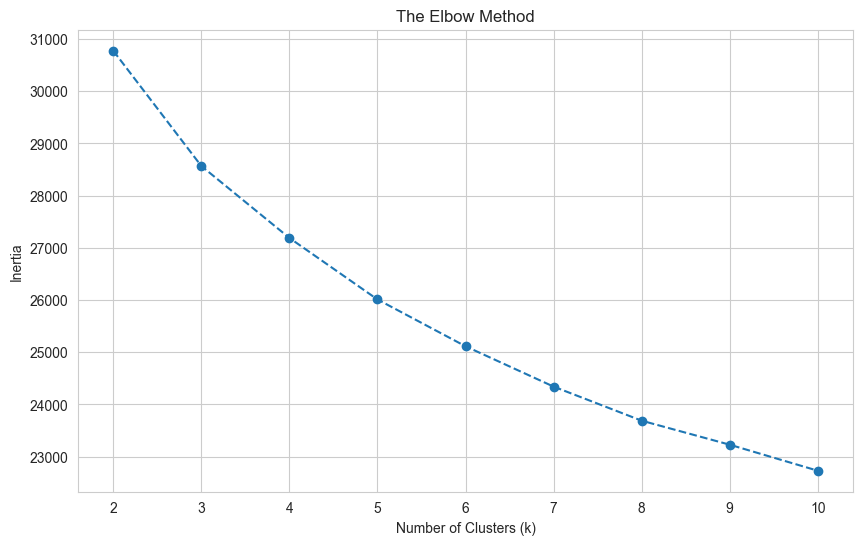

In [15]:
# range of cluster numbers from 2 to 10
k_range = range(2, 11)
inertia_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data)
    inertia_scores.append(kmeans.inertia_)

# Plot the results to find the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Silhouette Score for k = 2: 0.4813
Silhouette Score for k = 3: 0.0753
Silhouette Score for k = 4: 0.0655
Silhouette Score for k = 5: 0.0686
Silhouette Score for k = 6: 0.0685
Silhouette Score for k = 7: 0.0697
Silhouette Score for k = 8: 0.0690
Silhouette Score for k = 9: 0.0664
Silhouette Score for k = 10: 0.0677


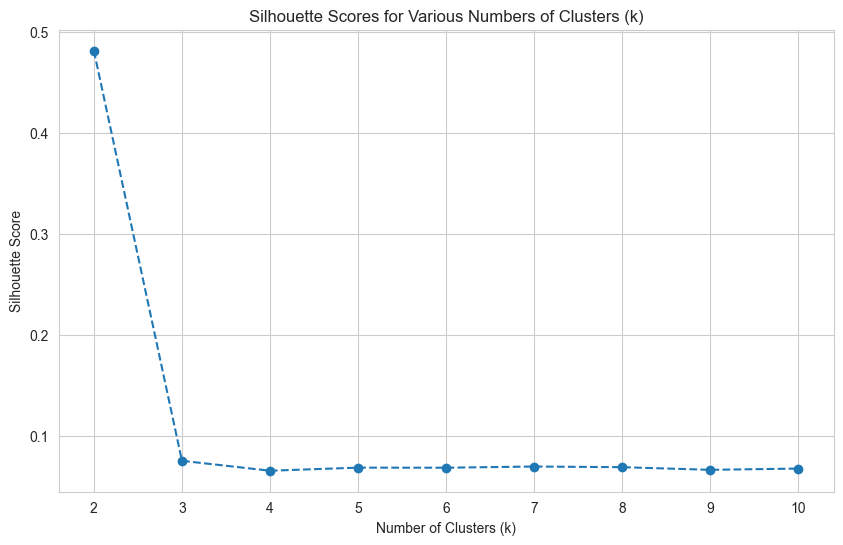

In [16]:
# We will test a range of cluster numbers from 2 to 10
k_range = range(2, 11)
silhouette_scores = []

# Loop through each possible number of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data)
    score = silhouette_score(processed_data, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k = {k}: {score:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Various Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [17]:
optimal_k = 2

# K-Means model
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(processed_data)

df['SpendingCluster'] = cluster_labels

print(f"K-Means model with {optimal_k} clusters has been trained successfully.")
df['SpendingCluster'].value_counts()

K-Means model with 2 clusters has been trained successfully.


SpendingCluster
1    2973
0      51
Name: count, dtype: int64

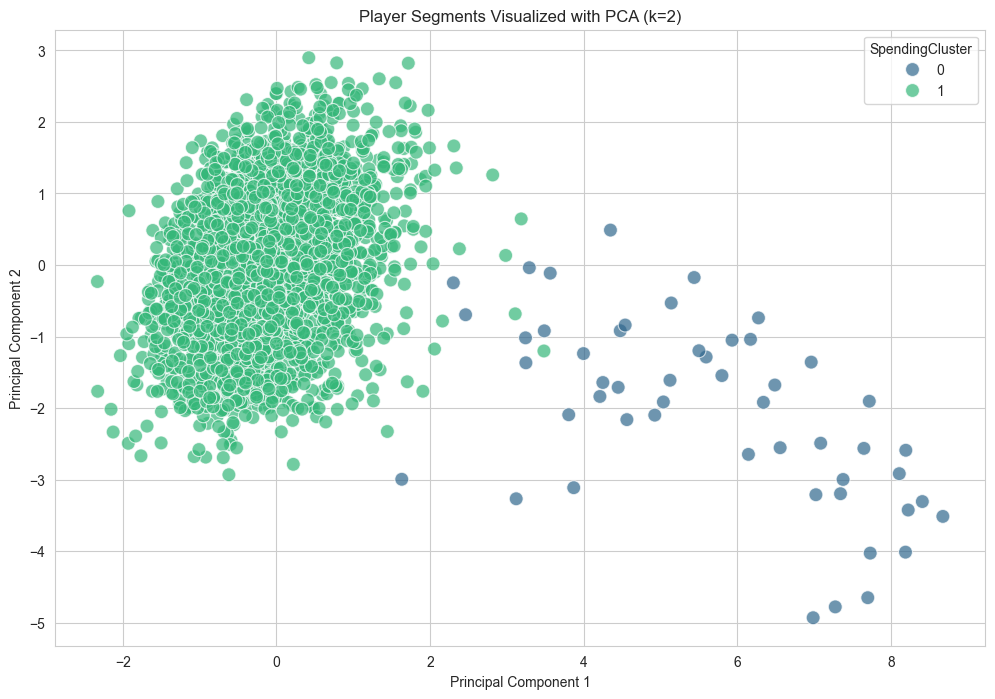

In [18]:
# Initialize PCA to reduce data to 2 dimensions for plotting
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(processed_data.toarray() if hasattr(processed_data, "toarray") else processed_data)

# Create a new DataFrame for plotting
df_pca = pd.DataFrame(data=data_pca, columns=['PCA1', 'PCA2'])
df_pca['SpendingCluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='SpendingCluster', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('Player Segments Visualized with PCA (k=2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='SpendingCluster')
plt.grid(True)
plt.show()

In [19]:
cluster_profile = df.groupby('SpendingCluster').mean(numeric_only=True)

print("Cluster Profiles (averages for numerical features):")
cluster_profile

Cluster Profiles (averages for numerical features):


,Age,SessionCount,AverageSessionLength,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek
SpendingCluster,,,,,,,,
0,34.764706,10.941176,18.992157,3211.787843,16.705882,2025.0,4.215686,2.901961
1,33.501850,10.059872,20.092536,45.101490,15.389506,2025.0,4.293979,3.017154


#### Not happy with current result will try something new now creating new dataset without InAppPurchaseAmount as it is creating problem

In [20]:
df_model_b = df.drop(columns=['UserID', 'LastPurchaseDate', 'SpendingSegment', 'InAppPurchaseAmount','SpendingCluster'])

categorical_features_b = df_model_b.select_dtypes(include="object").columns
numerical_features_b = df_model_b.select_dtypes(exclude="object").columns

preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_b),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_b)
    ])

processed_data_b = preprocessor_b.fit_transform(df_model_b)

print("--- Behavior-only data has been pre-processed successfully ---")
print("Shape of the new processed data:", processed_data_b.shape)
df_model_b.head()

--- Behavior-only data has been pre-processed successfully ---
Shape of the new processed data: (3024, 66)


,Age,Gender,Country,Device,GameGenre,SessionCount,AverageSessionLength,FirstPurchaseDaysAfterInstall,PaymentMethod,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek
0,49,Male,Norway,Android,Battle Royale,9,12.83,28,Apple Pay,2025,3,2
1,15,Male,Switzerland,iOS,Action RPG,11,19.39,18,Debit Card,2025,6,6
2,23,Male,China,Android,Fighting,9,8.87,30,Apple Pay,2025,6,0
3,31,Male,Mexico,Android,Racing,12,19.56,9,Debit Card,2025,4,1
4,37,Female,India,Android,Battle Royale,10,15.23,15,Paypal,2025,5,0


Behavior-Only Silhouette Score for k = 2: 0.0746
Behavior-Only Silhouette Score for k = 3: 0.0658
Behavior-Only Silhouette Score for k = 4: 0.0667
Behavior-Only Silhouette Score for k = 5: 0.0670
Behavior-Only Silhouette Score for k = 6: 0.0662
Behavior-Only Silhouette Score for k = 7: 0.0668
Behavior-Only Silhouette Score for k = 8: 0.0660
Behavior-Only Silhouette Score for k = 9: 0.0638
Behavior-Only Silhouette Score for k = 10: 0.0642


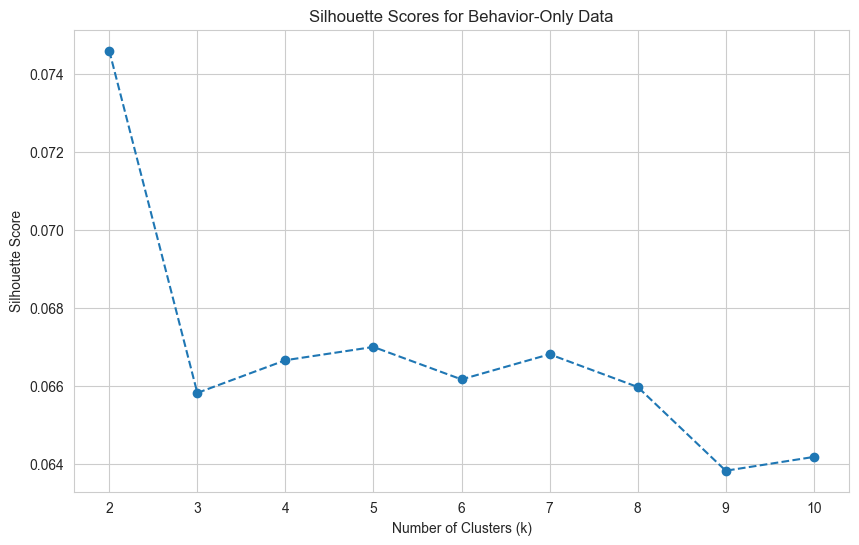

In [21]:
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(processed_data_b)
    score = silhouette_score(processed_data_b, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Behavior-Only Silhouette Score for k = {k}: {score:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Behavior-Only Data')
plt.xlabel('Number of Clusters (k)'); plt.ylabel('Silhouette Score')
plt.xticks(k_range); plt.grid(True); plt.show()

In [22]:
optimal_k = 2
kmeans_b = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)

cluster_labels_b = kmeans_b.fit_predict(processed_data_b)
df['BehaviorCluster'] = cluster_labels_b

print(df['BehaviorCluster'].value_counts())

BehaviorCluster
0    1539
1    1485
Name: count, dtype: int64


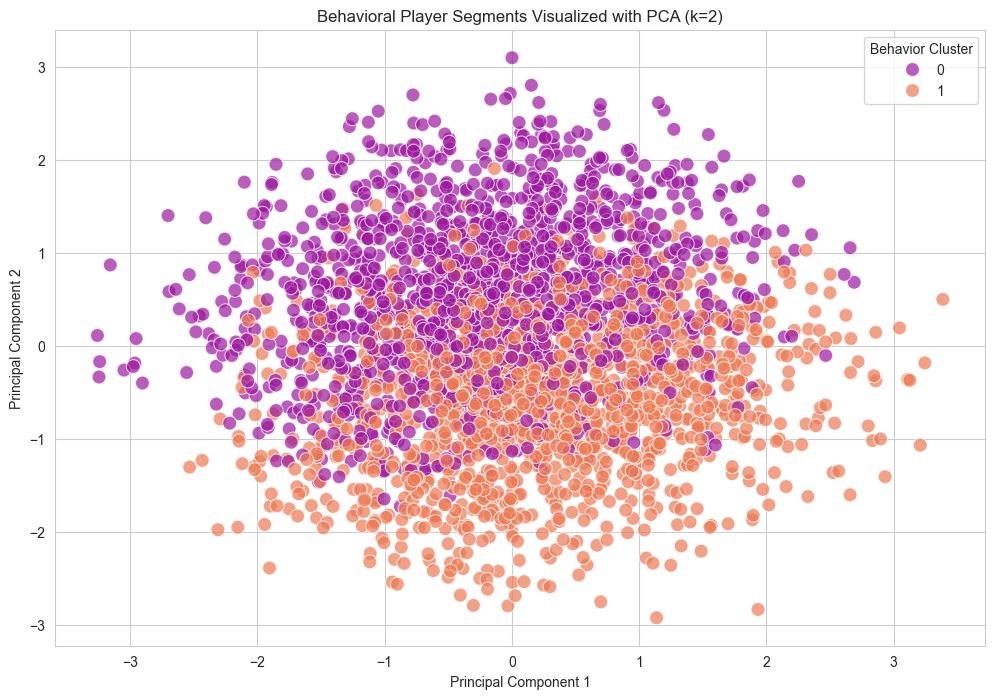

In [23]:
# We can reuse the PCA logic on the new processed_data to visualize these clusters
pca_b = PCA(n_components=2, random_state=42)
data_pca_b = pca_b.fit_transform(processed_data_b.toarray())

# Create a new DataFrame for plotting
df_pca_b = pd.DataFrame(data=data_pca_b, columns=['PCA1', 'PCA2'])
df_pca_b['BehaviorCluster'] = cluster_labels_b

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='BehaviorCluster', data=df_pca_b, palette='plasma', s=100, alpha=0.7)
plt.title('Behavioral Player Segments Visualized with PCA (k=2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Behavior Cluster')
plt.grid(True)
plt.show()

In [24]:
print("\n--- New, Corrected Behavioral Cluster Profiles (Averages) ---")
behavioral_profile = df.groupby('BehaviorCluster').mean(numeric_only=True)
behavioral_profile


--- New, Corrected Behavioral Cluster Profiles (Averages) ---


,Age,SessionCount,AverageSessionLength,InAppPurchaseAmount,FirstPurchaseDaysAfterInstall,LastPurchaseYear,LastPurchaseMonth,LastPurchaseDayOfWeek,SpendingCluster
BehaviorCluster,,,,,,,,,
0,33.100065,10.035088,27.362287,78.62744,15.389214,2025.0,4.430149,3.061728,0.988304
1,33.961616,10.115825,12.520640,119.11130,15.435017,2025.0,4.150168,2.967003,0.977778


In [25]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=4.5, min_samples=400)
dbscan_labels = dbscan.fit_predict(processed_data_b)

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_outliers = list(dbscan_labels).count(-1)

print(f"--- DBSCAN Analysis ---")
print(f"DBSCAN found {num_clusters} clusters and {num_outliers} outliers.")

# We can only calculate a silhouette score if more than 1 cluster is found.
if num_clusters > 1:
    dbscan_score = silhouette_score(processed_data_b, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_score:.4f}")
    print(f"For comparison, K-Means Score was: 0.0746")
else:
    print("DBSCAN did not find a stable cluster structure. K-Means remains the better model.")

--- DBSCAN Analysis ---
DBSCAN found 1 clusters and 0 outliers.
DBSCAN did not find a stable cluster structure. K-Means remains the better model.


# Model 1: Final Conclusion & Learnings

### What We Learned
This unsupervised analysis was a success and revealed several key insights:

1.  **Dominant Features Can Be Deceiving:** Our first model taught us a valuable lesson. The `InAppPurchaseAmount` was such a powerful feature that it completely masked all other behavioral patterns, leading to a simple but uninteresting "Whales vs. Everyone" segmentation. This highlights the importance of thoughtful feature selection.

2.  **Behavior is a Better Segmentor:** By removing the spending data, our second, corrected model was able to uncover a much more nuanced and actionable segmentation. It successfully identified two balanced and distinct behavioral personas.

3.  **Discovered Personas:** Our final champion model (K-Means on behavioral data) revealed two key player types:
    * **Persona 0: "The Dedicated Fans"**: This group is defined by high engagement, with an average session length more than double the other group. Their spending is moderate, suggesting they are motivated by the core gameplay.
    * **Persona 1: "The Efficient Spenders"**: This group plays in shorter, more focused bursts but has significantly higher average spending. They are likely using in-app purchases to save time and accelerate their progress.

This concludes our unsupervised analysis. We have successfully discovered two data-driven personas that can be used to inform targeted marketing and game design strategies.